# Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator, PercentFormatter
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
from functools import partial
from pathlib import Path

In [2]:
from composite_factor import plot_factor_distributions, composite_factor_calculation, weighted_composite_factor, plot_quantile_backtests_log
from operations import ts_decay
from portfolio_simulation import SimulationSettings, Simulation
from factor_selector import FactorSelector, single_factor_metrics
from portfolio_analyzer import PortfolioAnalyzer
from multi_manager import run_multimanager_backtest

In [3]:
# Load data
features_df = pd.read_csv('data/2.symbol_features_long.csv')
features_df['date'] = pd.to_datetime(features_df['date'])
features_df.set_index(["date", "symbol"], inplace=True)

factors_df = pd.read_csv('data/8.factors_df.csv')
factors_df['date'] = pd.to_datetime(factors_df['date'])
factors_df.set_index(['date', 'symbol'], inplace=True)

single_factor_returns = pd.read_csv('data/9.single_factor_returns.csv')
single_factor_returns['date'] = pd.to_datetime(single_factor_returns['date'])
single_factor_returns.set_index(['date'], inplace=True)

In [4]:
# Define returns, cap_flag, investability_flag and pre-simulation settings
returns = features_df['log_return']
cap_flag = features_df['cap_flag']
investability_flag = features_df['investability_flag']
com_factors_df = pd.DataFrame(index=factors_df.index)

# Default SimSettings use equal_weight and transaction_cost = True
SimSettings = partial(
    SimulationSettings,
    returns=returns,
    cap_flag=cap_flag,
    investability_flag=investability_flag,
    factors_df=com_factors_df,
    method='equal',
    transaction_cost=True,
    max_weight=0.01,
    pct=0.1,
    min_universe=100,
    contributor=False,
    output_summary=False,
    output_returns=False,
    plot=True
)

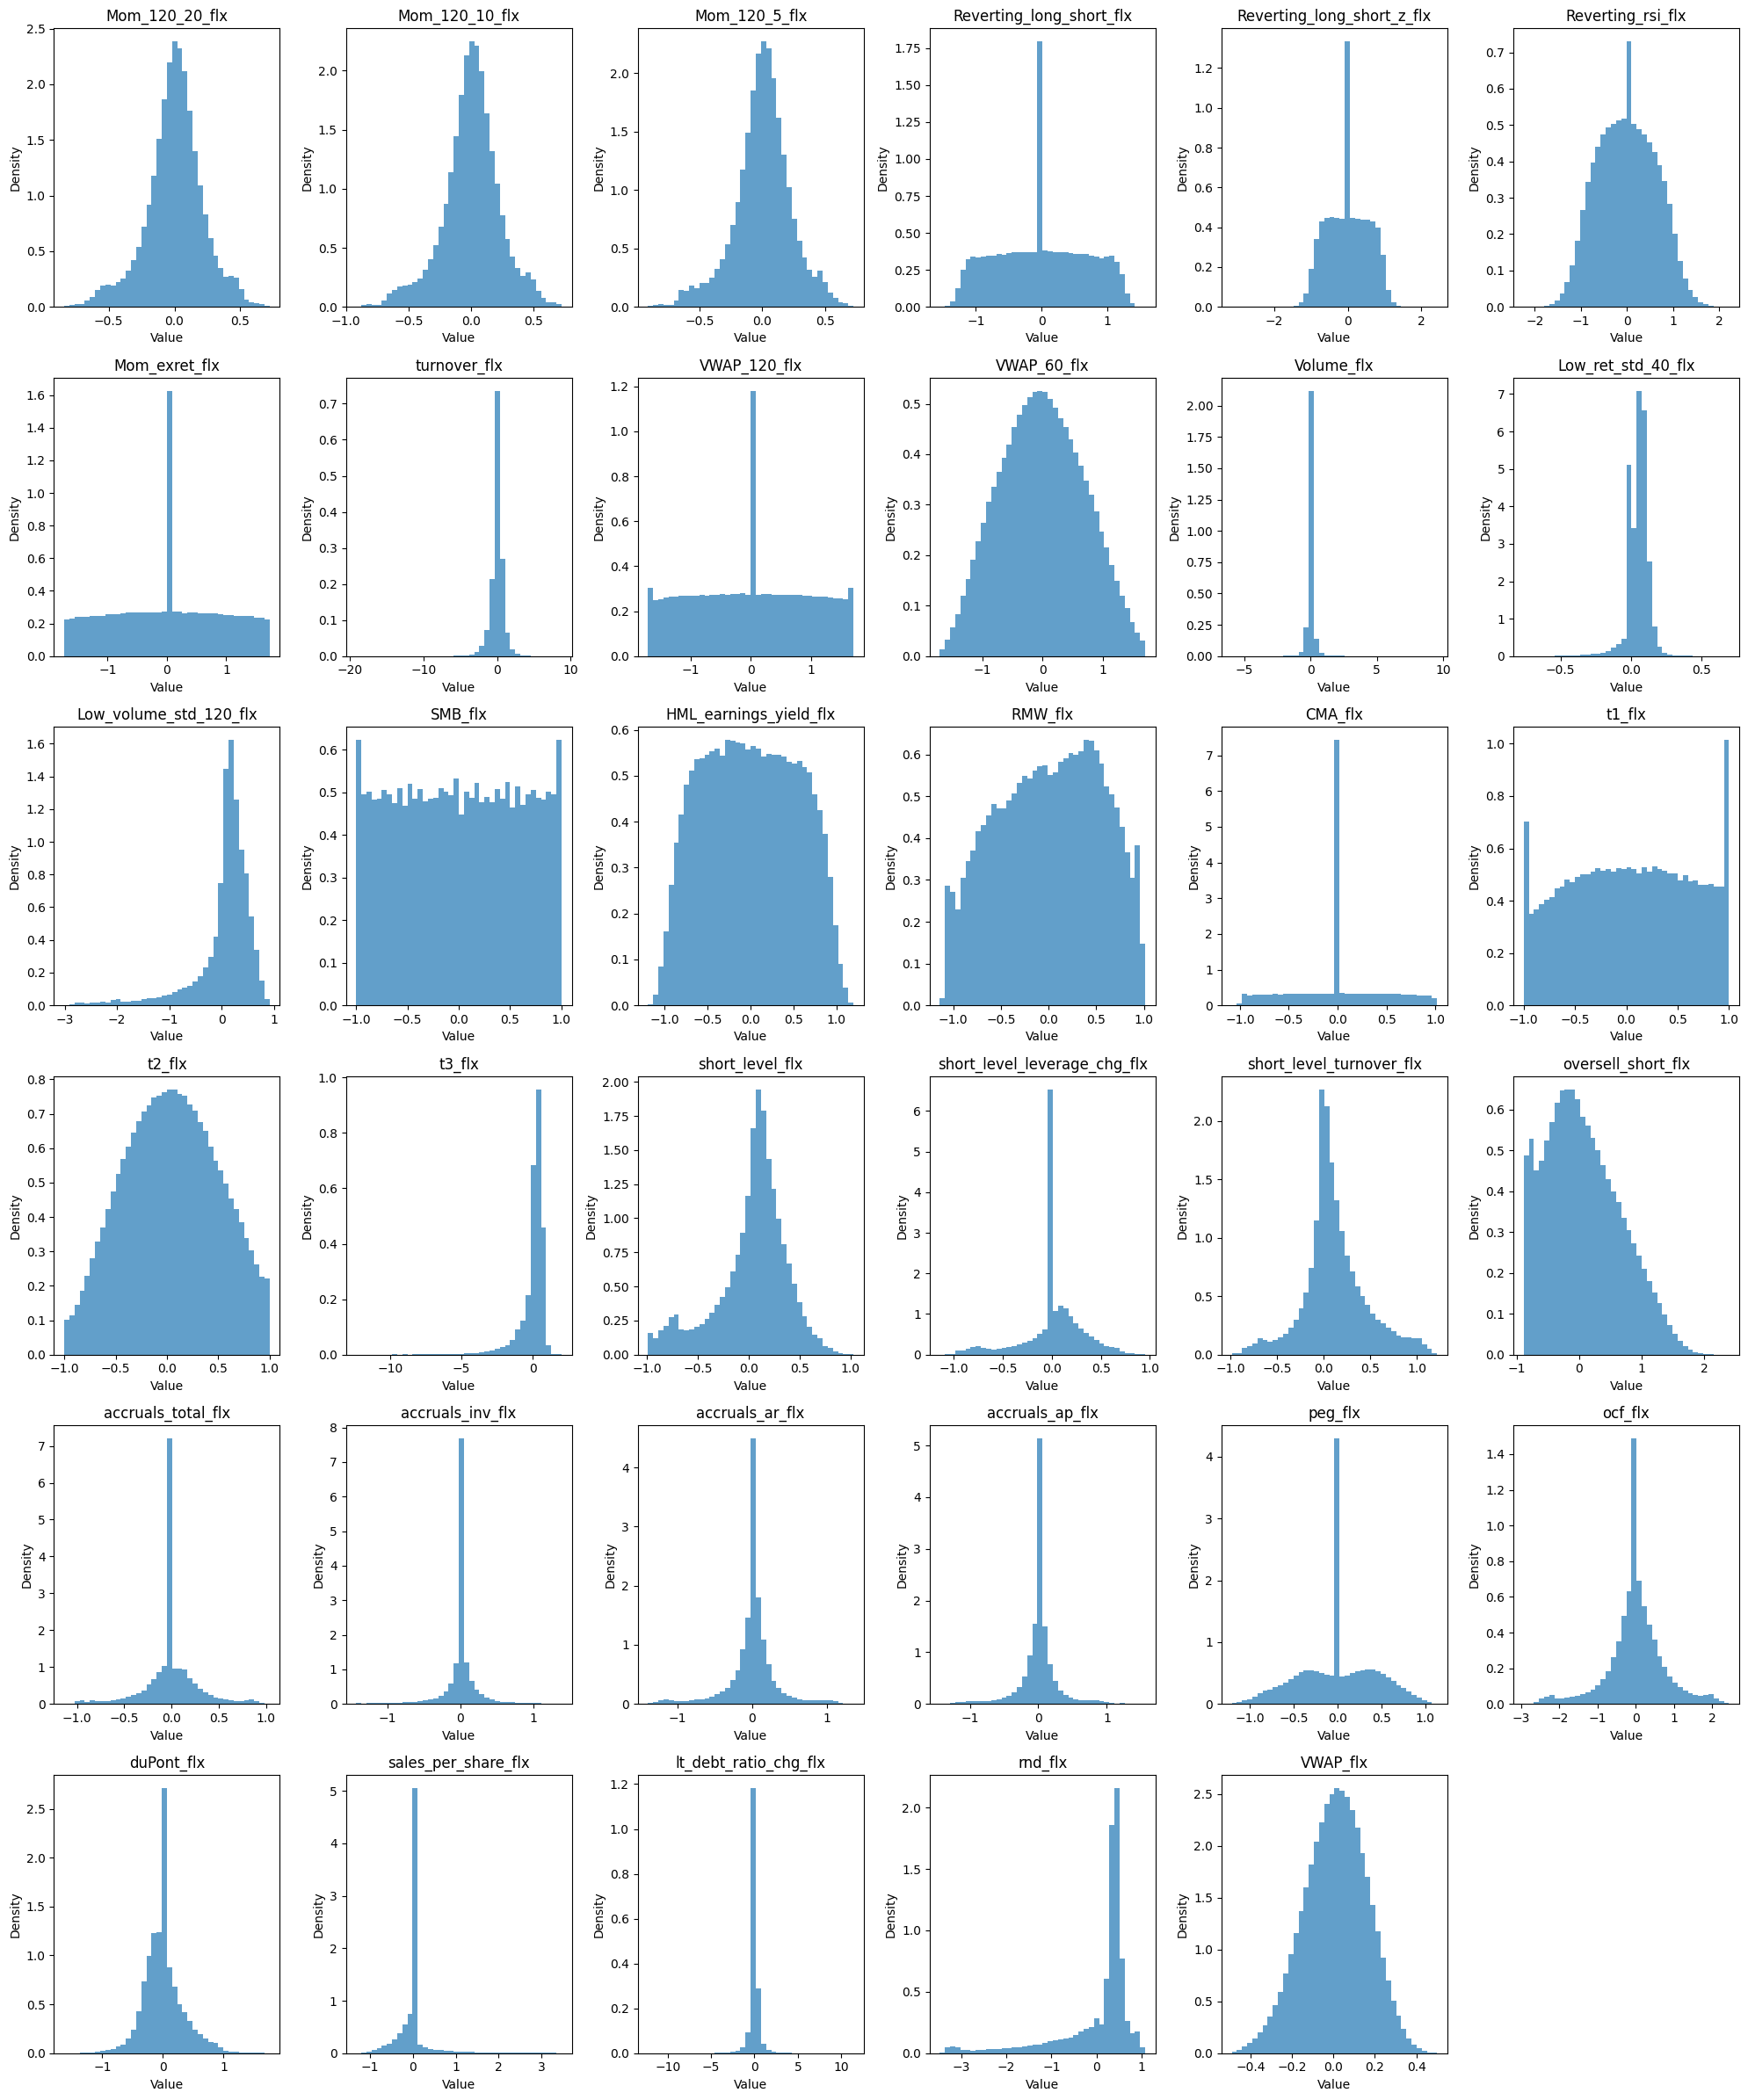

IC     IC_IR   rank_IC  rank_IC_IR  \
factor                                                                   
peg_flx                       0.005325  0.115278  0.005436    0.116972   
ocf_flx                       0.010269  0.112308  0.009227    0.113638   
duPont_flx                    0.006010  0.090696  0.006020    0.094741   
oversell_short_flx            0.009612  0.091220  0.010089    0.094705   
lt_debt_ratio_chg_flx         0.001349  0.044042  0.002850    0.085732   
short_level_leverage_chg_flx  0.004640  0.075725  0.006081    0.084789   
Reverting_rsi_flx             0.010025  0.077957  0.009735    0.077196   
short_level_flx               0.006376  0.074576  0.005827    0.073793   
Reverting_long_short_z_flx    0.009824  0.074357  0.009511    0.073223   
RMW_flx                       0.005151  0.071863  0.005167    0.072841   
Reverting_long_short_flx      0.009718  0.071738  0.009605    0.071414   
Mom_exret_flx                 0.009520  0.069585  0.009447    0.069449   
sales_per_share_flx          -0.000953 -0.017202  0.005531    0.068592   
turnover_flx                  0.013286  0.080053  0.010604    0.067716   
accruals_inv_flx              0.002042  0.071627  0.002035    0.063647   
short_level_turnover_flx      0.004731  0.077286  0.004504    0.062261   
Mom_120_5_flx                 0.010808  0.071237  0.008282    0.061886   
Mom_120_20_flx                0.009415  0.064210  0.007350    0.056662   
Mom_120_10_flx                0.009769  0.064935  0.007259    0.054684   
HML_earnings_yield_flx        0.005037  0.054710  0.005036    0.054533   
t1_flx                        0.007454  0.048353  0.007679    0.050049   
t2_flx                        0.007437  0.046869  0.007490    0.048006   
Low_ret_std_40_flx            0.008967  0.047936  0.007816    0.043127   
VWAP_flx                      0.006350  0.047959  0.005317    0.042316   
Volume_flx                   -0.000722 -0.009908  0.001524    0.029395   
Low_volume_std_120_flx        0.004190  0.032114  0.001794    0.016592   
VWAP_120_flx                  0.000537  0.010511  0.000550    0.010801   
rnd_flx                      -0.001362 -0.011988  0.000197    0.001798   
CMA_flx                      -0.000034 -0.000745 -0.000163   -0.003652   
accruals_total_flx            0.000256  0.008389 -0.000282   -0.009836   
accruals_ar_flx              -0.000743 -0.025125 -0.000407   -0.012930   
t3_flx                       -0.000201 -0.002754 -0.001660   -0.016962   
VWAP_60_flx                  -0.004390 -0.048281 -0.003803   -0.043375   
accruals_ap_flx              -0.000426 -0.016868 -0.001317   -0.045048   
SMB_flx                      -0.007332 -0.061120 -0.007330   -0.061111   

                              factor_return_tstat  factor_return_pvalue  \
factor                                                                    
peg_flx                                  4.250133              0.000023   
ocf_flx                                  3.312649              0.000949   
duPont_flx                               2.811121              0.005014   
oversell_short_flx                       2.599696              0.009439   
lt_debt_ratio_chg_flx                   -0.577480              0.563723   
short_level_leverage_chg_flx             2.915214              0.003615   
Reverting_rsi_flx                        0.184934              0.853313   
short_level_flx                          3.347910              0.000838   
Reverting_long_short_z_flx               1.516284              0.129722   
RMW_flx                                  2.140809              0.032473   
Reverting_long_short_flx                 0.303706              0.761407   
Mom_exret_flx                            0.648815              0.516587   
sales_per_share_flx                     -0.277878              0.781155   
turnover_flx                             2.213675              0.027048   
accruals_inv_flx                         2.213826              0.027027   
short_level_turnover_f

In [5]:
# Calculate factor analysis metrics
factor_analysis_metrics = single_factor_metrics(factors_df, returns)
factor_analysis_metrics.to_csv('data/10.factor_analysis_metrics.csv')
plot_factor_distributions(factors_df, exclude=['log_return'], bins=40, ncols=6, figsize=(20, 4))
factor_analysis_metrics

# Full time Period

In [18]:
# Prepare Full Sample Factor Selection
factor_analysis_metrics = pd.read_csv('data/10.factor_analysis_metrics.csv', index_col=0)
selected_factors = factor_analysis_metrics.index[factor_analysis_metrics['rank_IC_IR'] > -1].to_list()

In [19]:
def plot_decay_sensitivity(
    composite_factor: pd.Series,
    settings: SimulationSettings,
    decay_period: list[int] = [1, 3, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350],
    figsize: tuple[int, int] = (12, 6)
):
    """
    For each decay window d, re‐compute the factor via ts_decay, run the simulation,
    and plot annualized return (left axis) & Sharpe ratio (right axis) versus d.
    """
    annret_list = []
    sharpe_list = []
    settings.output_returns = True
    settings.plot = False
    for d in tqdm(decay_period, desc="Decay windows"):
        # decay the factor
        feat = ts_decay(composite_factor, d).rename("custom_feature")

        # run the simulation
        sim = Simulation(
            name=f"decay_{d}",
            custom_feature=feat,
            settings=settings,
        )
        result_df = sim.run()

        # extract the daily net returns
        daily_r = result_df["log_return"]

        # annualized return = (prod(1+r))^(252/N) - 1
        annret = (np.prod(1 + daily_r)) ** (252 / len(daily_r)) - 1
        # Sharpe ratio = mean(r)/std(r) * sqrt(252)
        sharpe = daily_r.mean() / daily_r.std() * np.sqrt(252)

        annret_list.append(annret)
        sharpe_list.append(sharpe)

    # plotting
    fig, ax1 = plt.subplots(figsize=figsize)

    # left axis: Annualized Return
    ax1.plot(decay_period, annret_list,
             marker='*', linestyle='-',
             label="Annualized Return")
    ax1.set_xlabel("Decay Window Length")
    ax1.set_ylabel("Annualized Return", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(decay_period)
    ax1.set_xlim(min(decay_period), max(decay_period))
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=6, prune='both'))
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))

    # right axis: Sharpe Ratio
    ax2 = ax1.twinx()
    ax2.plot(decay_period, sharpe_list,
             marker='o', linestyle='--',
             color='tab:orange', label="Sharpe Ratio")
    ax2.set_ylabel("Sharpe Ratio", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.title("Annualized Return & Sharpe vs. Decay Window")
    plt.tight_layout()
    plt.show()

### Zscore composite factor

In [20]:
com_factor_zscore = composite_factor_calculation(factors_df, selected_factors, method='zscore')
settings_com_factor_z_eq = SimSettings()

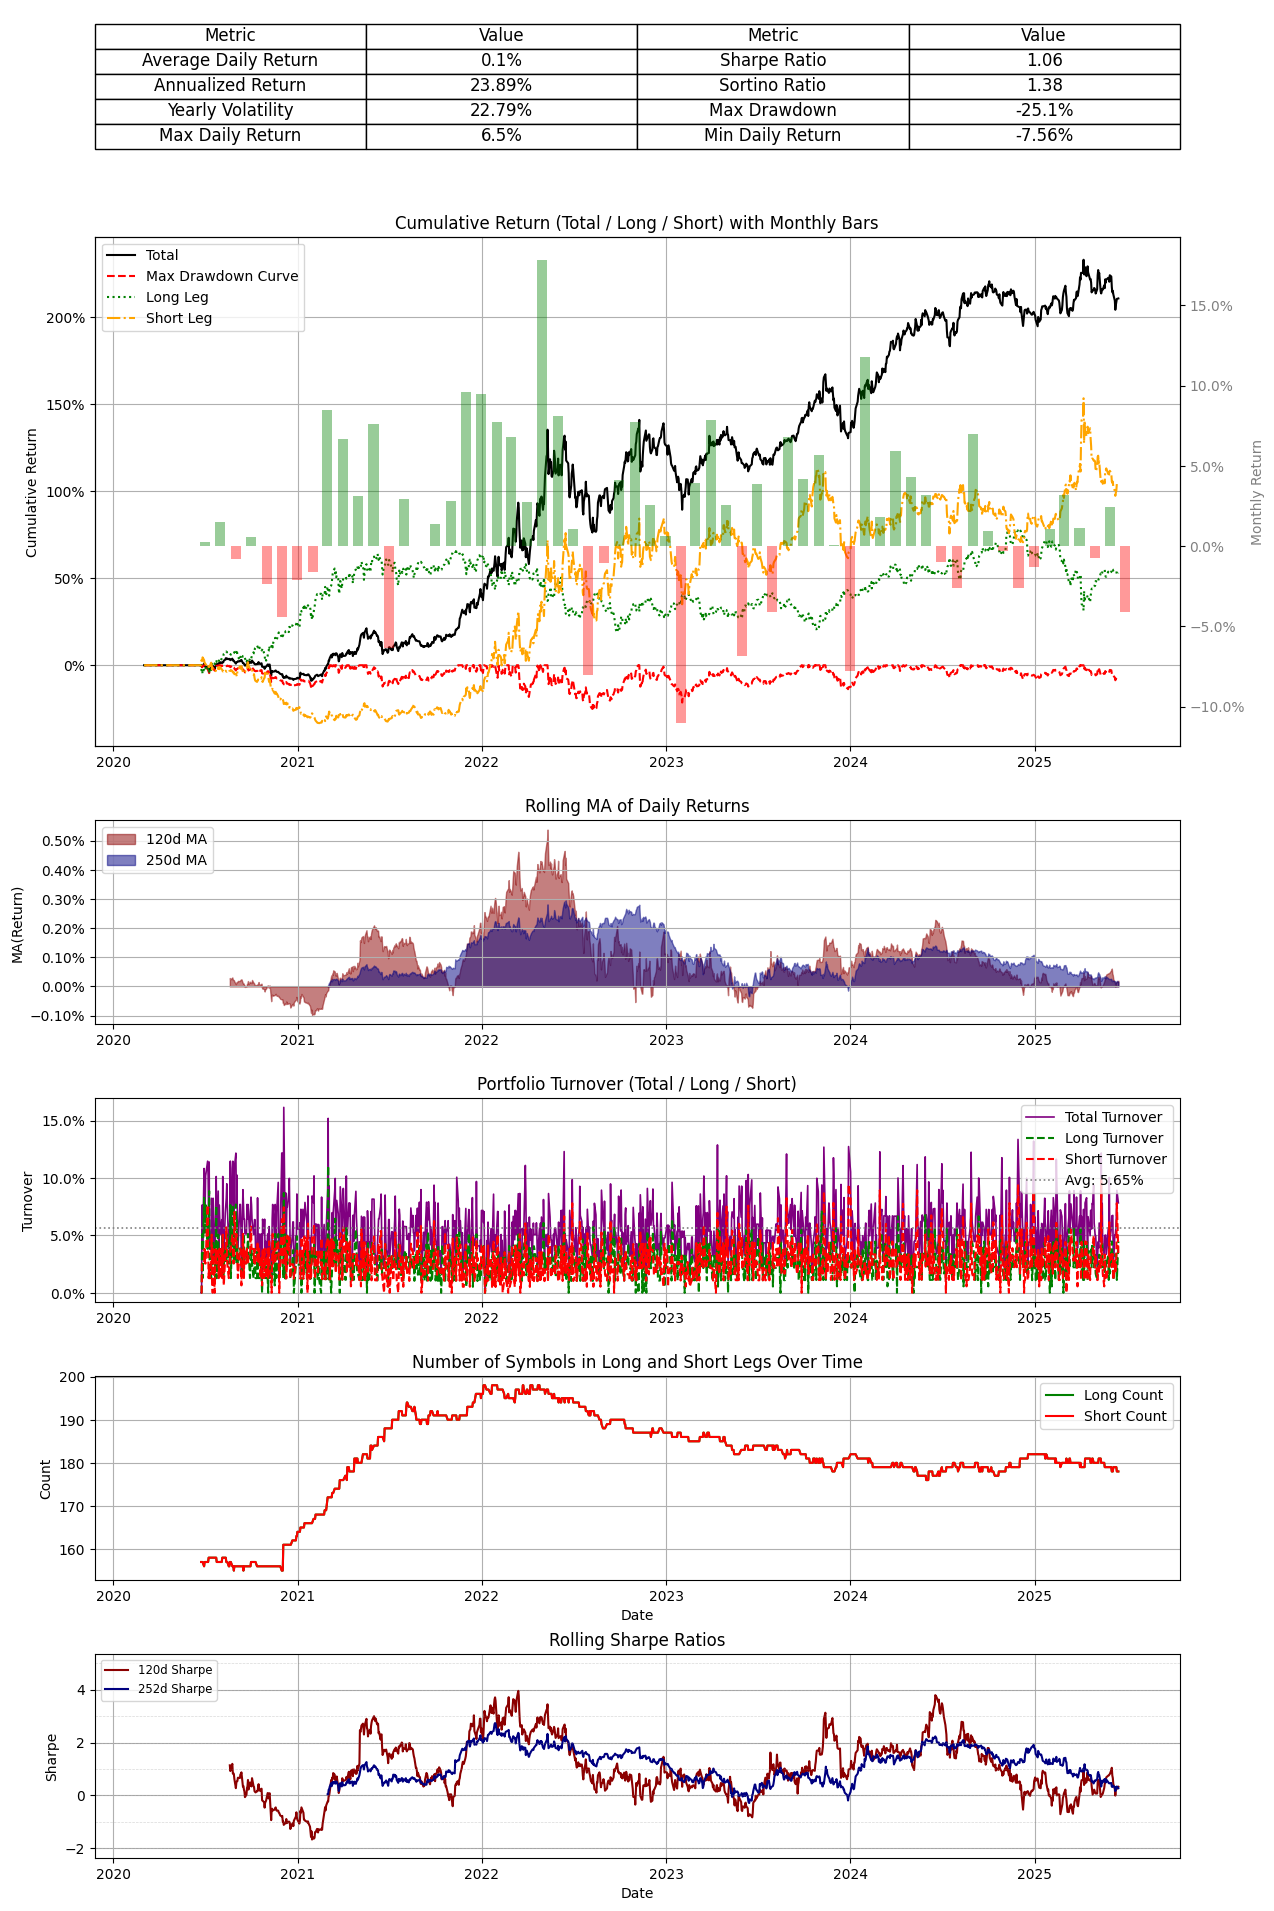

In [21]:
custom_feature = ts_decay(com_factor_zscore, 80).rename("custom_feature")
simulation_com_factor_z_eq_decay_80 = Simulation('com_factor_z_eq_decay_80', custom_feature, settings_com_factor_z_eq)
simulation_com_factor_z_eq_decay_80.run()

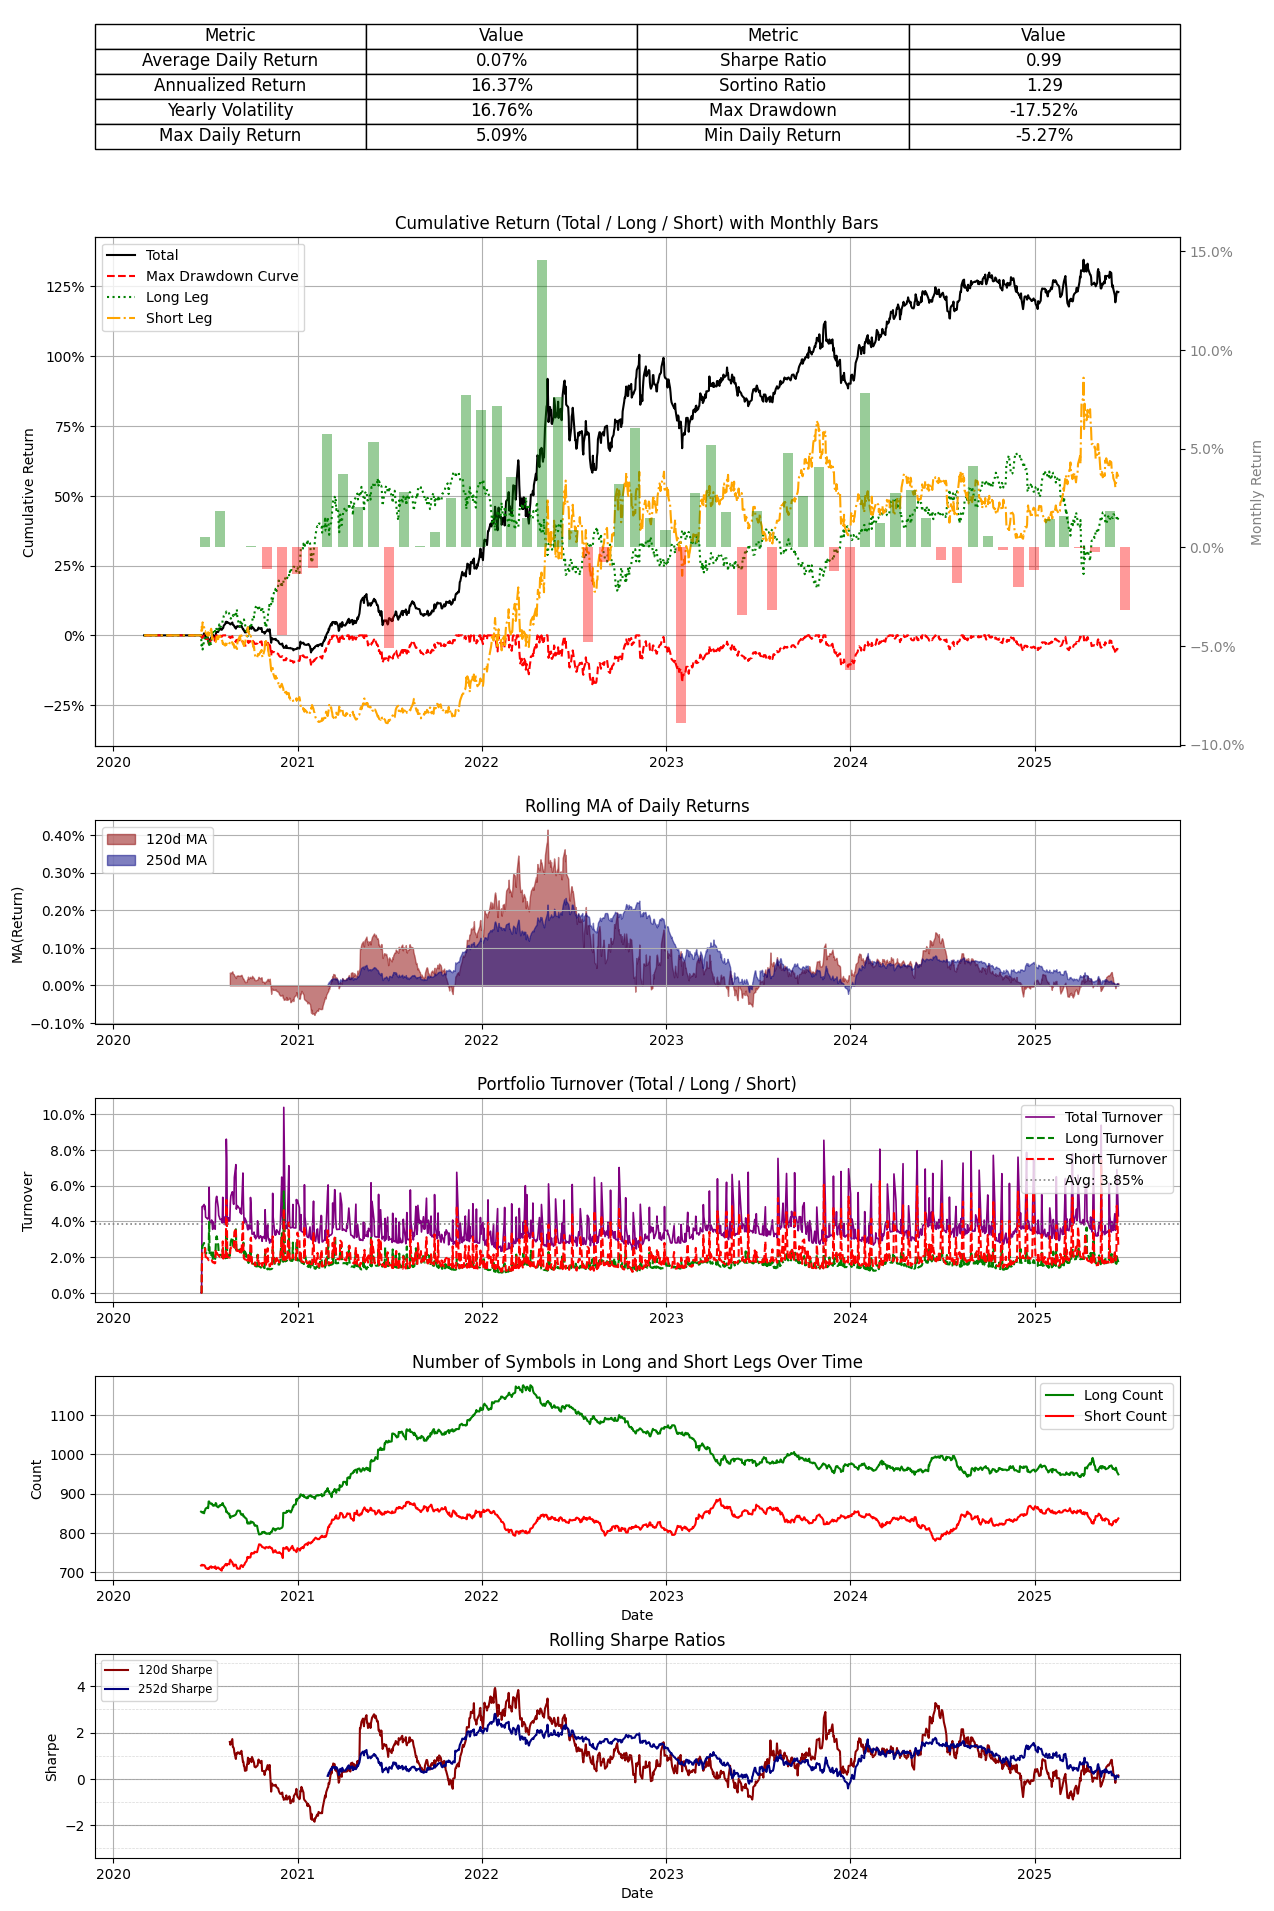

In [22]:
custom_feature = ts_decay(com_factor_zscore, 80).rename("custom_feature")
settings_com_factor_z_flex = SimSettings(method='linear')
simulation_com_factor_z_flex_decay_80 = Simulation('com_factor_z_flex_decay_80', custom_feature, settings_com_factor_z_flex)
simulation_com_factor_z_flex_decay_80.run()

In [23]:
# Sensitivity with regard to decay window
# plot_decay_sensitivity(com_factor_zscore, settings_com_factor_z_eq)

### Rank composite factor

In [24]:
com_factor_rank = composite_factor_calculation(factors_df, selected_factors, method='rank')
settings_com_factor_rank_flex = SimSettings(method='linear', plot=False, output_summary=True) # Update settings to linear method

In [25]:
custom_feature = ts_decay(com_factor_rank, 150).rename("custom_feature")

simulation_com_factor_rank_flex_decay_150 = Simulation('com_factor_rank_flex_decay_150', custom_feature, settings_com_factor_rank_flex)
simulation_com_factor_rank_flex_decay_150.run()

 IC (%)  IC_IR (%)  IC_Std (%)  Avg Turnover (%)
   0.77        8.1        9.49              2.71
              Metric   Value
Average Daily Return   0.04%
   Annualized Return  11.15%
   Yearly Volatility   9.55%
    Max Daily Return   2.99%
        Sharpe Ratio    1.15
       Sortino Ratio    1.52
        Max Drawdown -11.92%
    Min Daily Return  -3.23%


In [26]:
# Sensitivity with regard to decay window
# plot_decay_sensitivity(com_factor_rank, settings_com_factor_rank_flex)

# Rolling Window Factor Selection

## Factor Selection

In [ ]:
print("=== Running ICIR-based factor selection ===")
factor_selector_icir = FactorSelector(
    factors_df=factors_df,
    returns=returns,
    factor_ret_df=single_factor_returns,
    window=60,
    method='icir_top',
    method_kwargs={'top_x': 5, 'icir_threshold': -1}
)

# Prepare factor selection
factor_weights_icir = factor_selector_icir.prepare_selection()
out_path = Path('data/factor_weights/factor_weights_icir.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
factor_weights_icir.to_csv(out_path)
print(f"ICIR method average non-zero weights: {(factor_weights_icir > 0).sum(axis=1).mean():.2f}")
print(factor_weights_icir)

In [ ]:
print("=== Running Momentum-based factor selection ===")
factor_selector_momentum = FactorSelector(
    factors_df=factors_df,
    returns=returns,
    factor_ret_df=single_factor_returns,
    window=60,
    method='momentum',
    method_kwargs={
        'max_weight': 0.3,     # Maximum weight per factor
    }
)

# Prepare factor selection with Momentum
factor_weights_momentum = factor_selector_momentum.prepare_selection()

factor_weights_momentum.to_csv('data/factor_weights/factor_weights_momentum.csv')
print(f"Momentum method average non-zero weights: {(factor_weights_momentum > 0).sum(axis=1).mean():.2f}")
print(factor_weights_momentum)

In [ ]:
print("=== Running MVO-based factor selection with shrinkage ===")
factor_selector_mvo = FactorSelector(
    factors_df=factors_df,
    returns=returns,
    factor_ret_df=single_factor_returns,
    window=60,
    method='mvo',
    method_kwargs={
        'risk_aversion': 1.0,  # Trade-off between return and risk
        'max_weight': 0.3,     # Maximum weight per factor
        'turnover_penalty': 0.5,  # Penalty for weight changes (reduces turnover)
        'use_shrinkage': False  # Apply Ledoit-Wolf shrinkage to covariance matrix
    }
)

# Prepare factor selection with MVO and shrinkage
factor_weights_mvo = factor_selector_mvo.prepare_selection()
factor_weights_mvo.to_csv('data/factor_weights/factor_weights_mvo.csv')

print(f"MVO method average non-zero weights: {(factor_weights_mvo > 0).sum(axis=1).mean():.2f}")
print(factor_weights_mvo)

## Composite Factor Calculation

In [6]:
factor_weights_icir = pd.read_csv('data/factor_weights/factor_weights_icir.csv')
factor_weights_icir['date'] = pd.to_datetime(factor_weights_icir['date'])
factor_weights_icir.set_index('date', inplace=True)

factor_weights_momentum = pd.read_csv('data/factor_weights/factor_weights_momentum.csv')
factor_weights_momentum['date'] = pd.to_datetime(factor_weights_momentum['date'])
factor_weights_momentum.set_index('date', inplace=True)

factor_weights_mvo = pd.read_csv('data/factor_weights/factor_weights_mvo.csv')
factor_weights_mvo['date'] = pd.to_datetime(factor_weights_mvo['date'])
factor_weights_mvo.set_index('date', inplace=True)

In [7]:
composite_factor_icir_zscore = weighted_composite_factor(factors_df, factor_weights_icir, method='zscore')
composite_factor_momentum_zscore = weighted_composite_factor(factors_df, factor_weights_momentum, method='zscore')
composite_factor_mvo_zscore = weighted_composite_factor(factors_df, factor_weights_mvo, method='zscore')
composite_factor_icir_zscore.to_csv('data/composite_factors/composite_factor_icir_zscore.csv', index=True)
composite_factor_momentum_zscore.to_csv('data/composite_factors/composite_factor_momentum_zscore.csv', index=True)
composite_factor_mvo_zscore.to_csv('data/composite_factors/composite_factor_mvo_zscore.csv', index=True)

In [8]:
# composite_factor_icir_rank = weighted_composite_factor(factors_df, factor_weights_icir, method='rank')
# composite_factor_momentum_rank = weighted_composite_factor(factors_df, factor_weights_momentum, method='rank')
# composite_factor_mvo_rank = weighted_composite_factor(factors_df, factor_weights_mvo, method='rank')
# composite_factor_icir_rank.to_csv('data/composite_factors/composite_factor_icir_rank.csv', index=True)
# composite_factor_momentum_rank.to_csv('data/composite_factors/composite_factor_momentum_rank.csv', index=True)
# composite_factor_mvo_rank.to_csv('data/composite_factors/composite_factor_mvo_rank.csv', index=True)

## Composite Factor Result

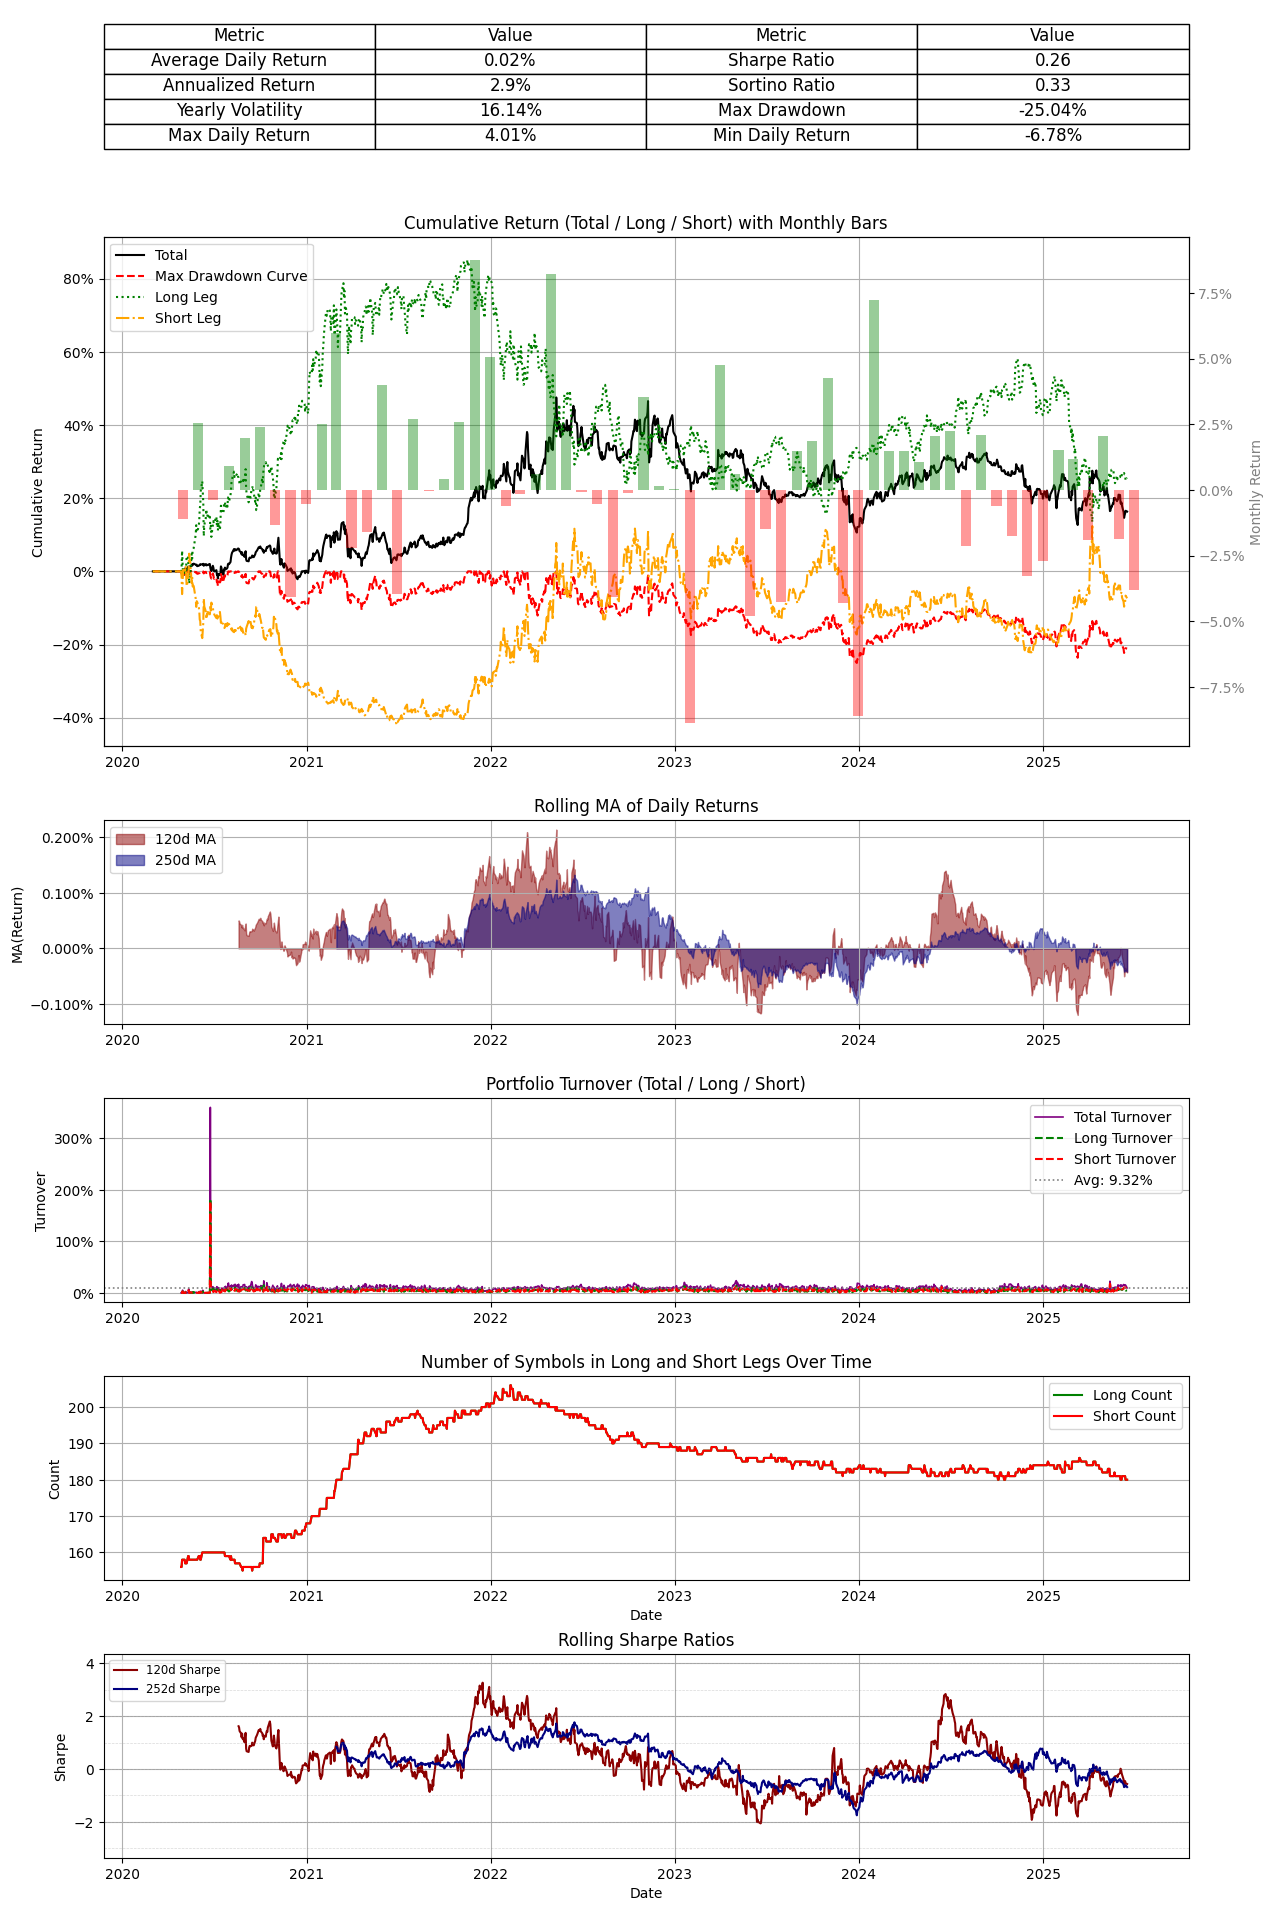

In [9]:
# ICIR composite factor
composite_factor_icir_zscore = pd.read_csv('data/composite_factors/composite_factor_icir_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
composite_factor_icir_zscore = composite_factor_icir_zscore.squeeze()
settings_icir_composite = SimSettings() 

custom_feature = ts_decay(composite_factor_icir_zscore, 80).rename("custom_feature").fillna(0)
simulation_icir_composite = Simulation('com_factor_icir_eq', custom_feature, settings_icir_composite)
simulation_icir_composite.run()

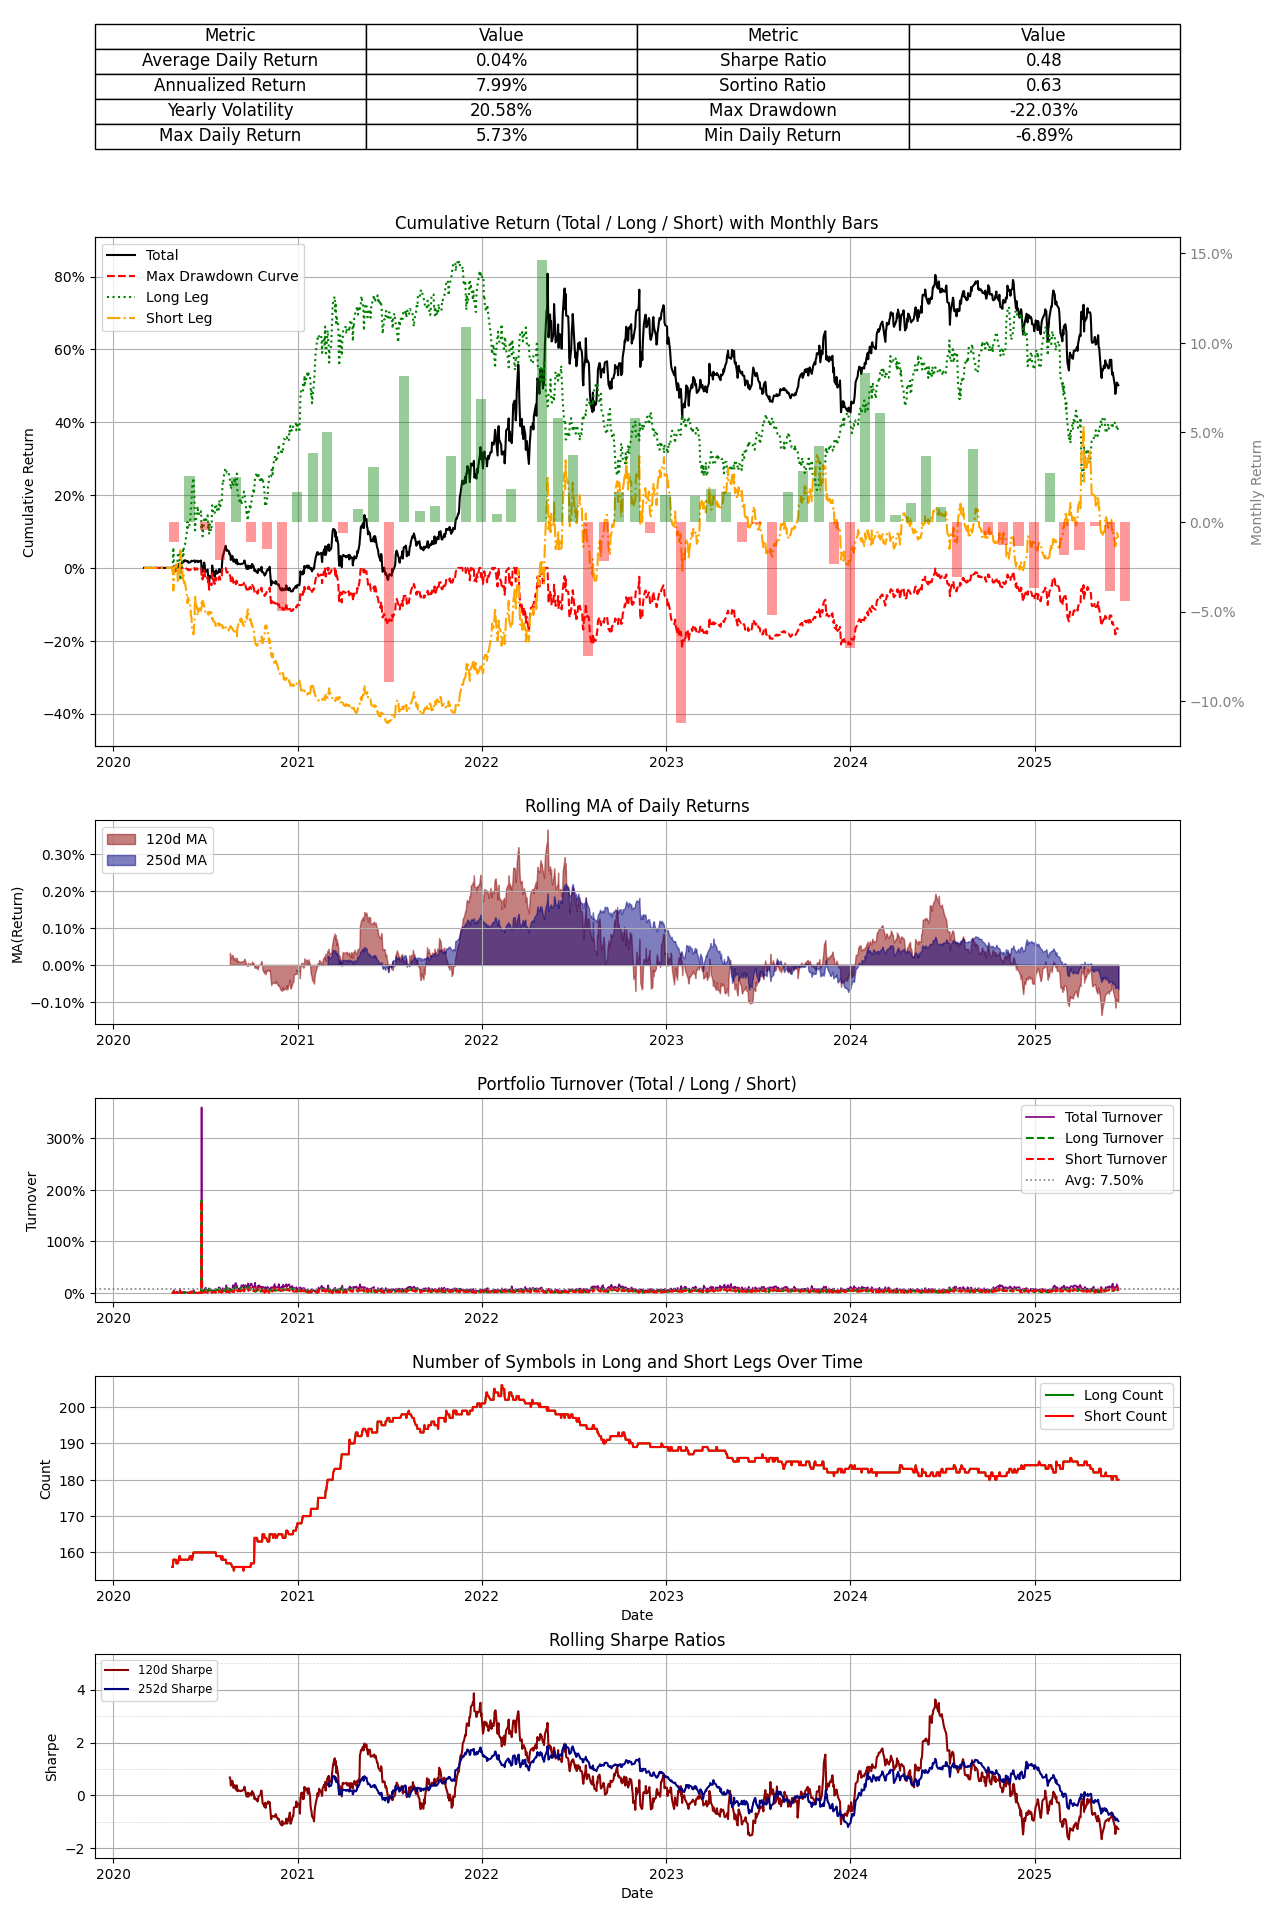

In [10]:
# Momentum composite factor
composite_factor_momentum_zscore = pd.read_csv('data/composite_factors/composite_factor_momentum_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
composite_factor_momentum_zscore = composite_factor_momentum_zscore.squeeze()
settings_momentum_composite = SimSettings() 

custom_feature = ts_decay(composite_factor_momentum_zscore, 80).rename("custom_feature").fillna(0)
simulation_momentum_composite = Simulation('com_factor_momentum_eq', custom_feature, settings_momentum_composite)
simulation_momentum_composite.run()

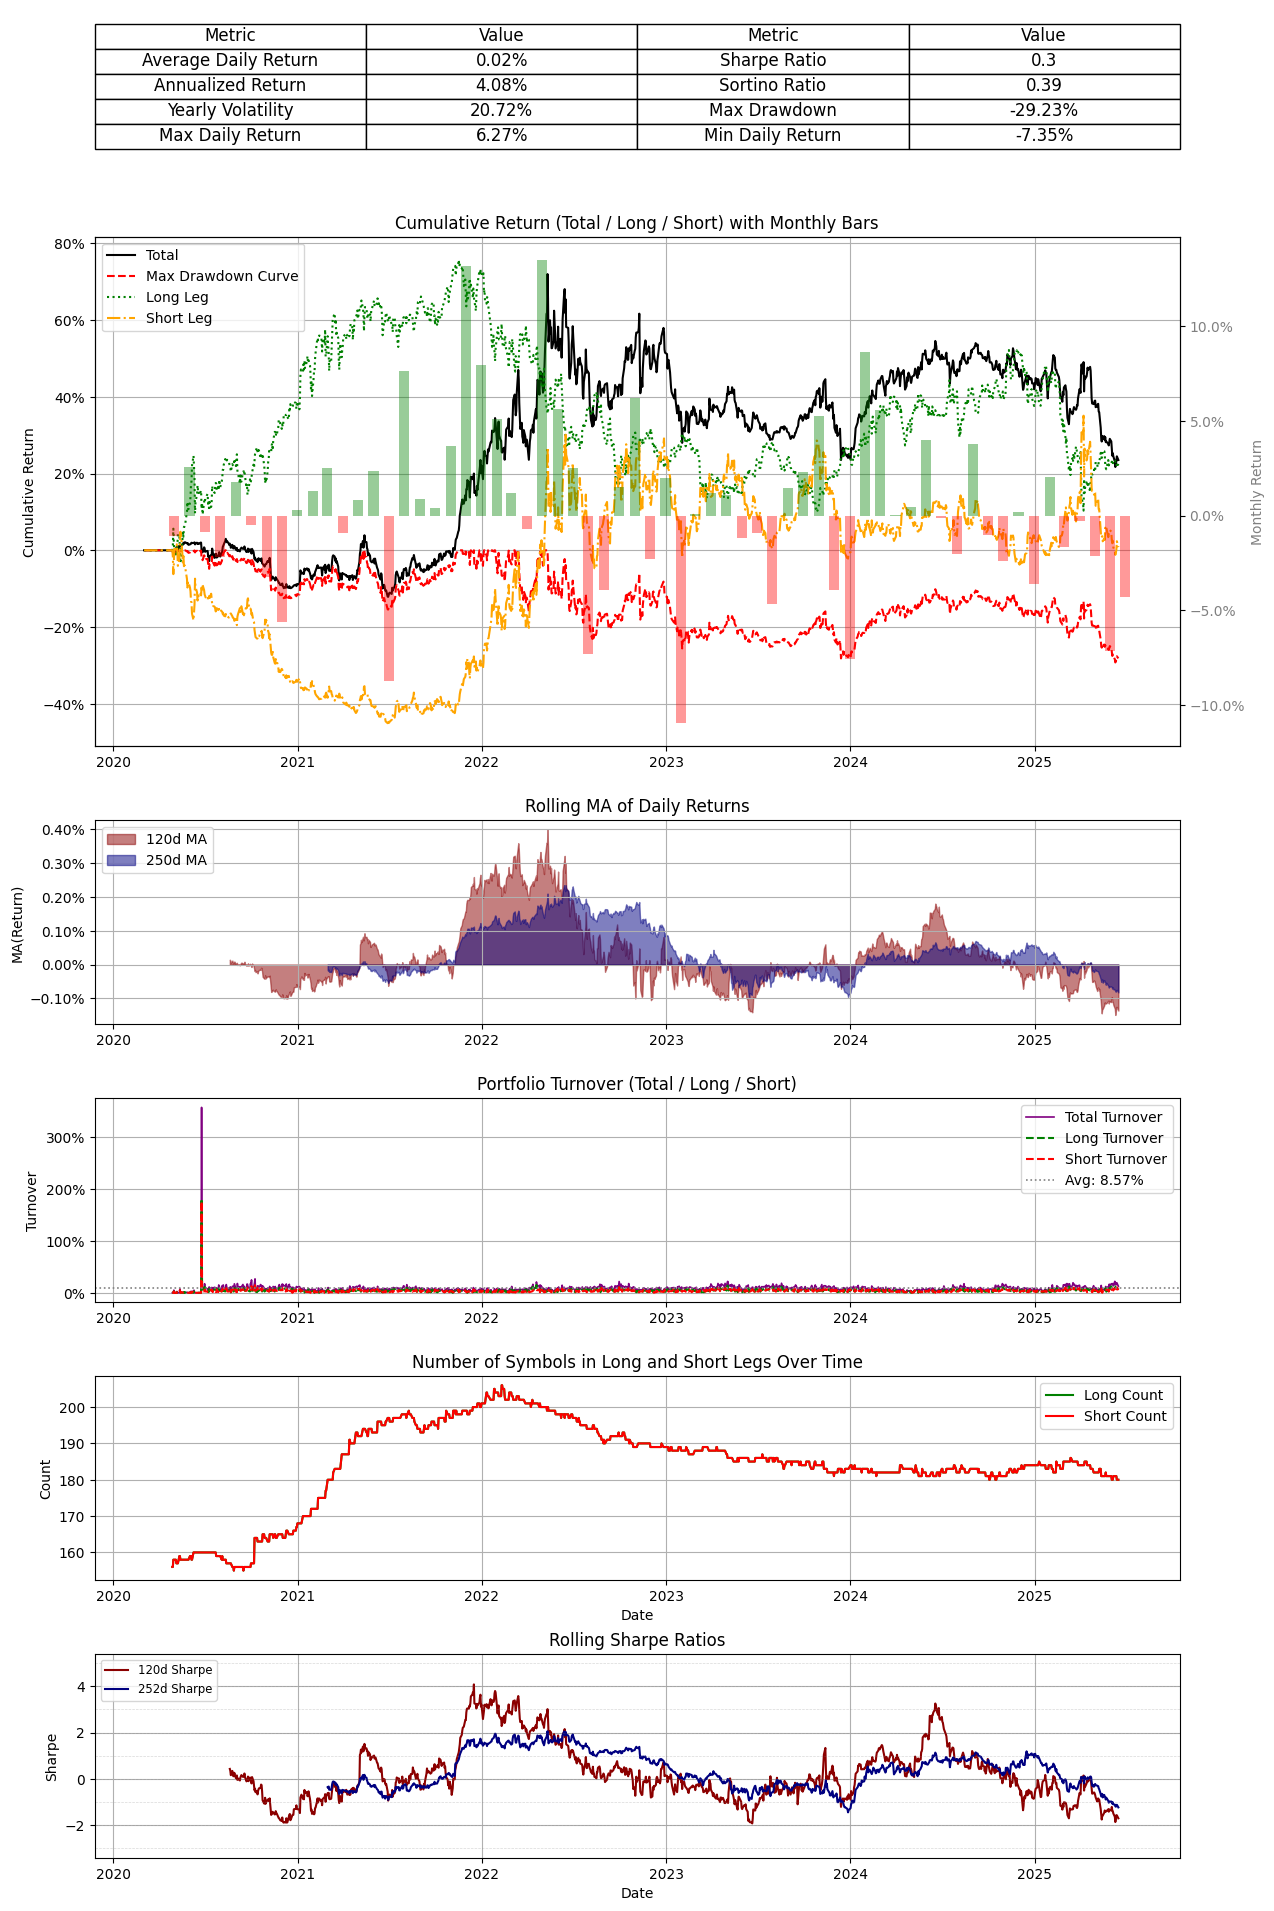

In [11]:
# MVO composite factor
composite_factor_mvo_zscore = pd.read_csv('data/composite_factors/composite_factor_mvo_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
composite_factor_mvo_zscore = composite_factor_mvo_zscore.squeeze()
settings_mvo_composite = SimSettings() 

custom_feature = ts_decay(composite_factor_mvo_zscore, 80).rename("custom_feature").fillna(0)
simulation_mvo_composite = Simulation('com_factor_mvo_eq', custom_feature, settings_mvo_composite)
simulation_mvo_composite.run()

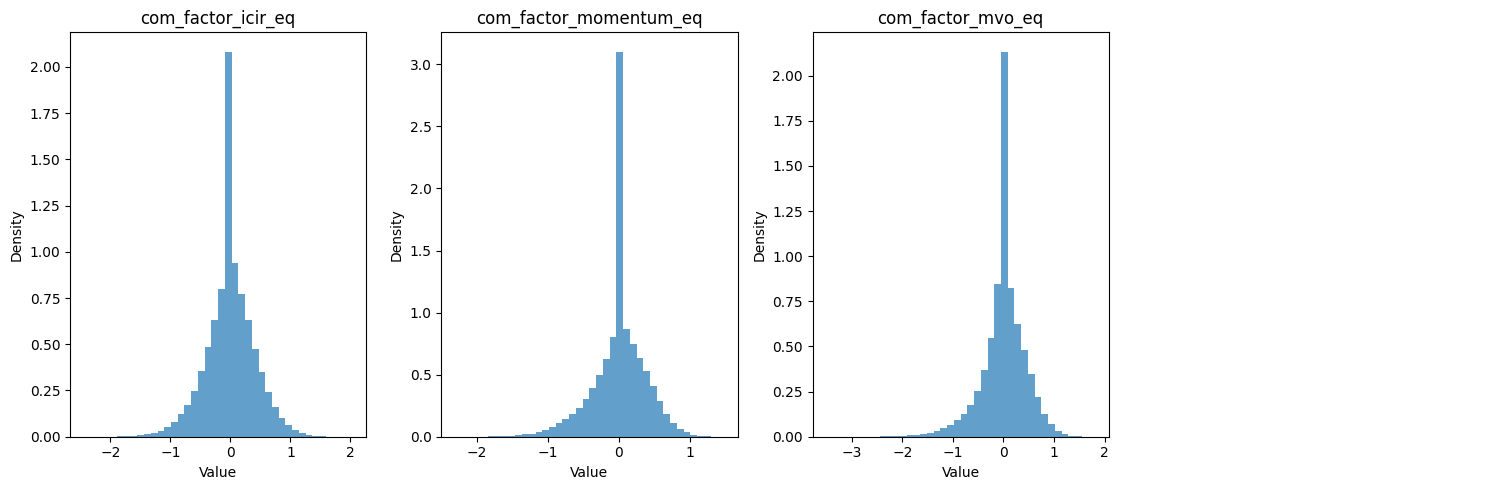

In [12]:
com_factors_df.to_csv('data/com_factors_df.csv', index=True)
com_factors_df = pd.read_csv('data/com_factors_df.csv')
com_factors_df['date'] = pd.to_datetime(com_factors_df['date'])
com_factors_df = com_factors_df.set_index(["date", "symbol"])
plot_factor_distributions(com_factors_df, exclude=['log_return'], bins=40, ncols=4)

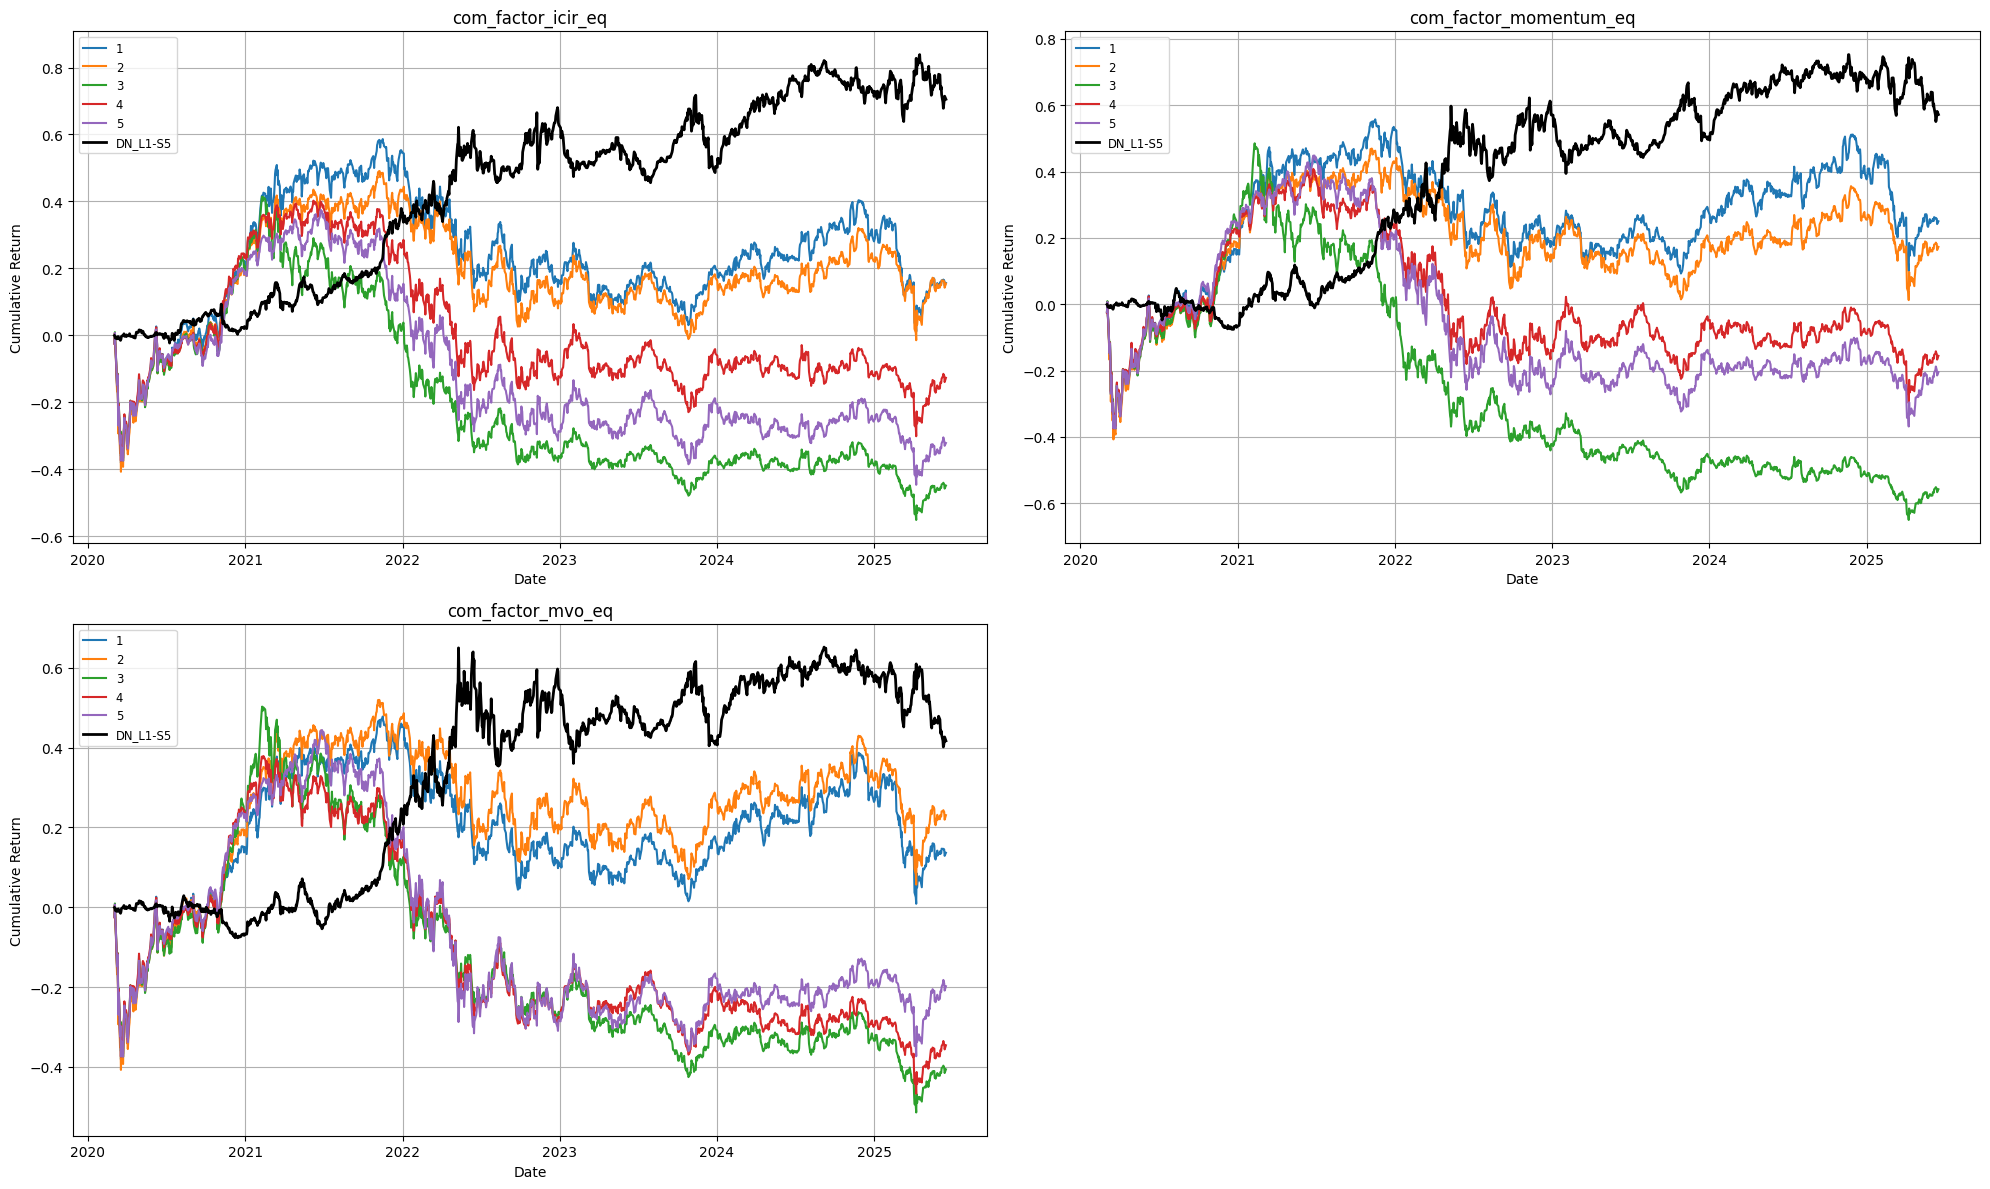

In [13]:
plot_quantile_backtests_log(
    com_factors_df=com_factors_df,
    returns=returns,
    n_groups=5,
    ncols=2)

## Multi Manager

In [14]:
factor_weights_icir = pd.read_csv('data/factor_weights/factor_weights_icir.csv')
factor_weights_icir['date'] = pd.to_datetime(factor_weights_icir['date'])
factor_weights_icir.set_index('date', inplace=True)

factor_weights_momentum = pd.read_csv('data/factor_weights/factor_weights_momentum.csv')
factor_weights_momentum['date'] = pd.to_datetime(factor_weights_momentum['date'])
factor_weights_momentum.set_index('date', inplace=True)

factor_weights_mvo = pd.read_csv('data/factor_weights/factor_weights_mvo.csv')
factor_weights_mvo['date'] = pd.to_datetime(factor_weights_mvo['date'])
factor_weights_mvo.set_index('date', inplace=True)

2025-07-28 12:36:24 INFO     multi_manager Computing multimanager portfolio weights and counts...
2025-07-28 12:40:10 INFO     multi_manager Running backtest...


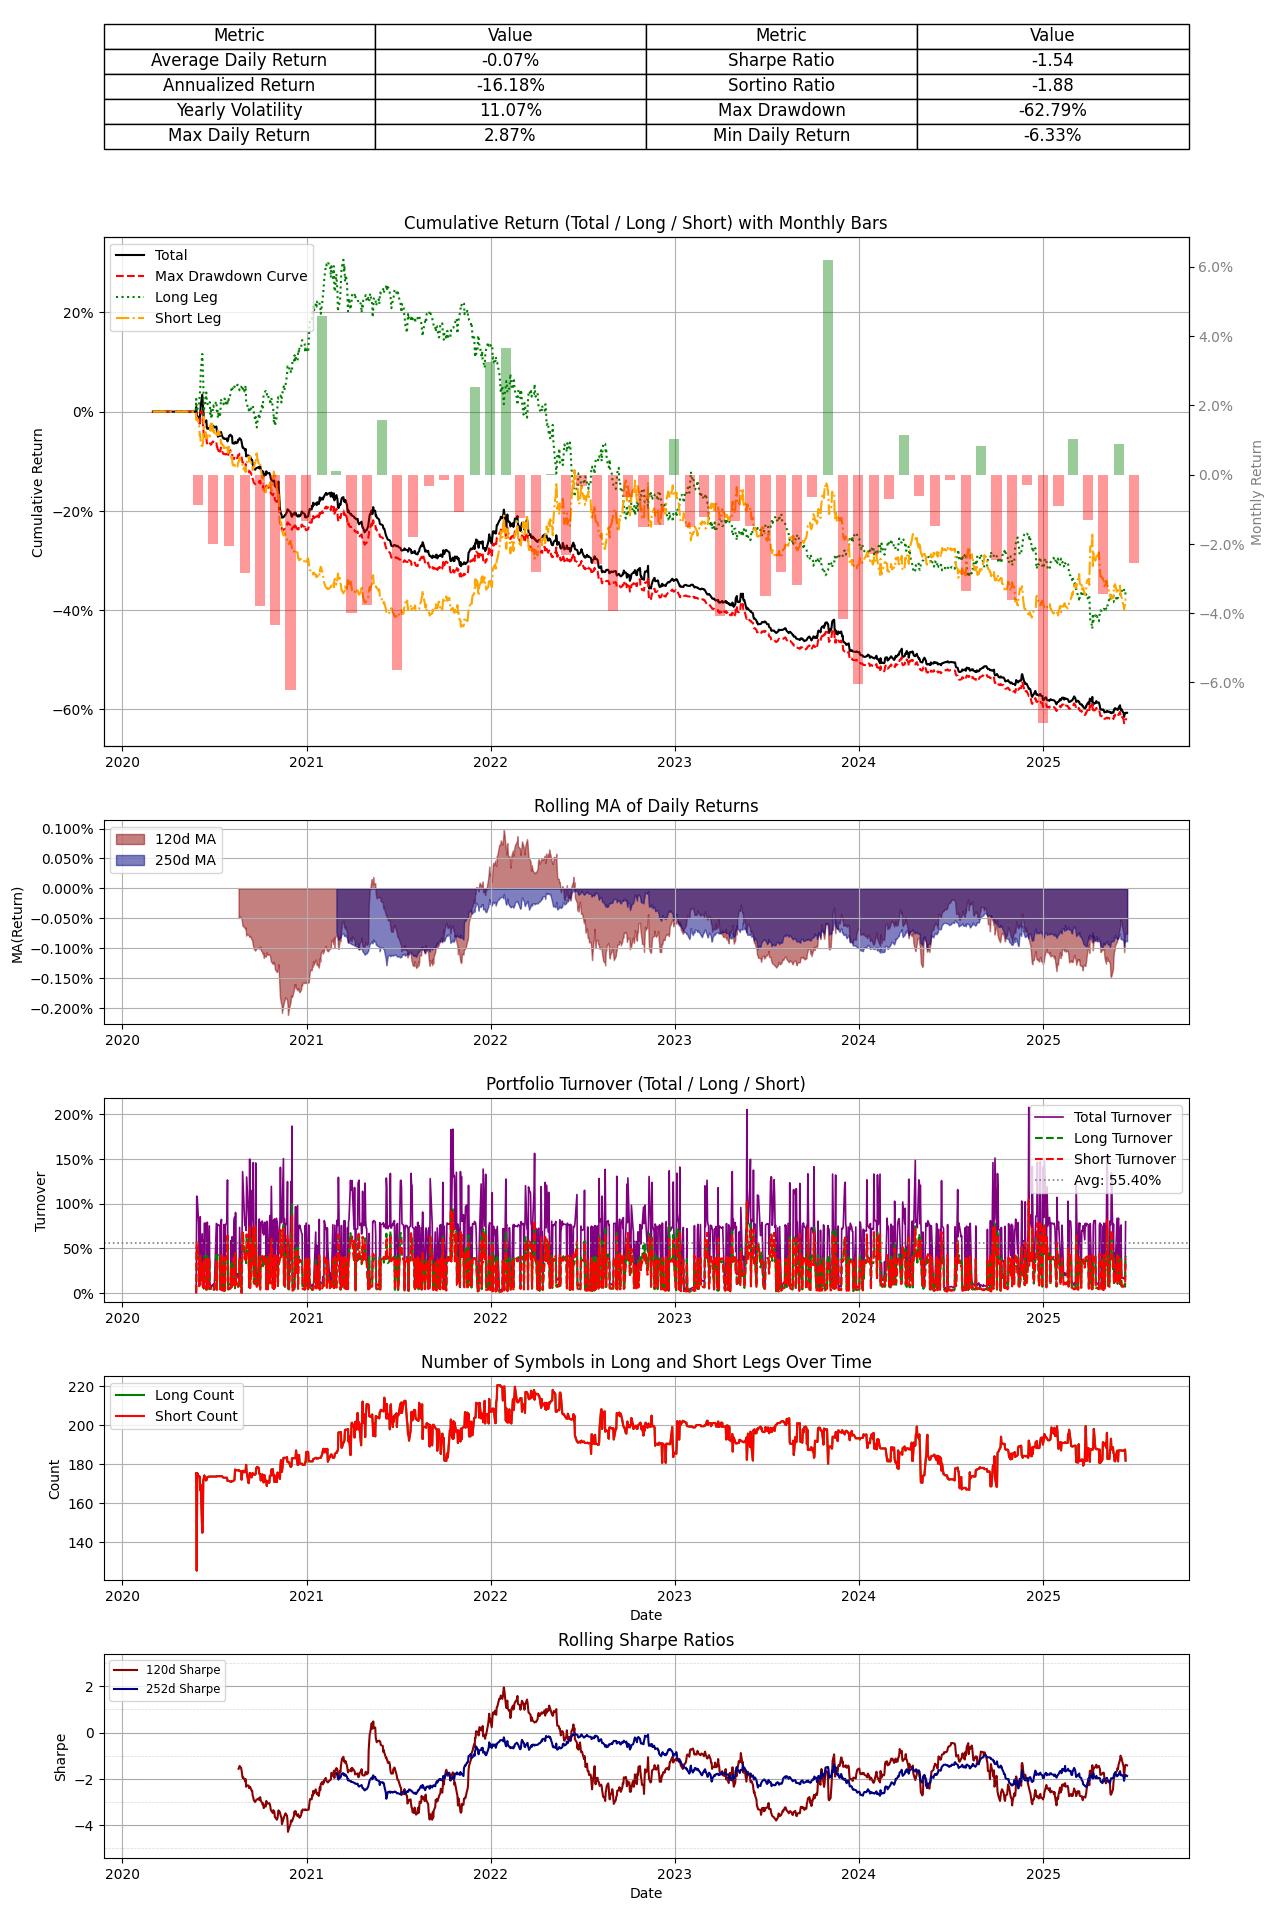

In [15]:
settings_icir_multimanager = SimSettings()

multi_manager_icir, top_longs_icir, top_shorts_icir, counts_icir = run_multimanager_backtest(factors_df, returns, cap_flag, factor_weights_icir, settings_icir_multimanager)
analysis_icir = PortfolioAnalyzer(multi_manager_icir)
analysis_icir.plot_full_performance(counts_df=counts_icir)

2025-07-28 12:40:15 INFO     multi_manager Computing multimanager portfolio weights and counts...
2025-07-28 12:44:28 INFO     multi_manager Running backtest...


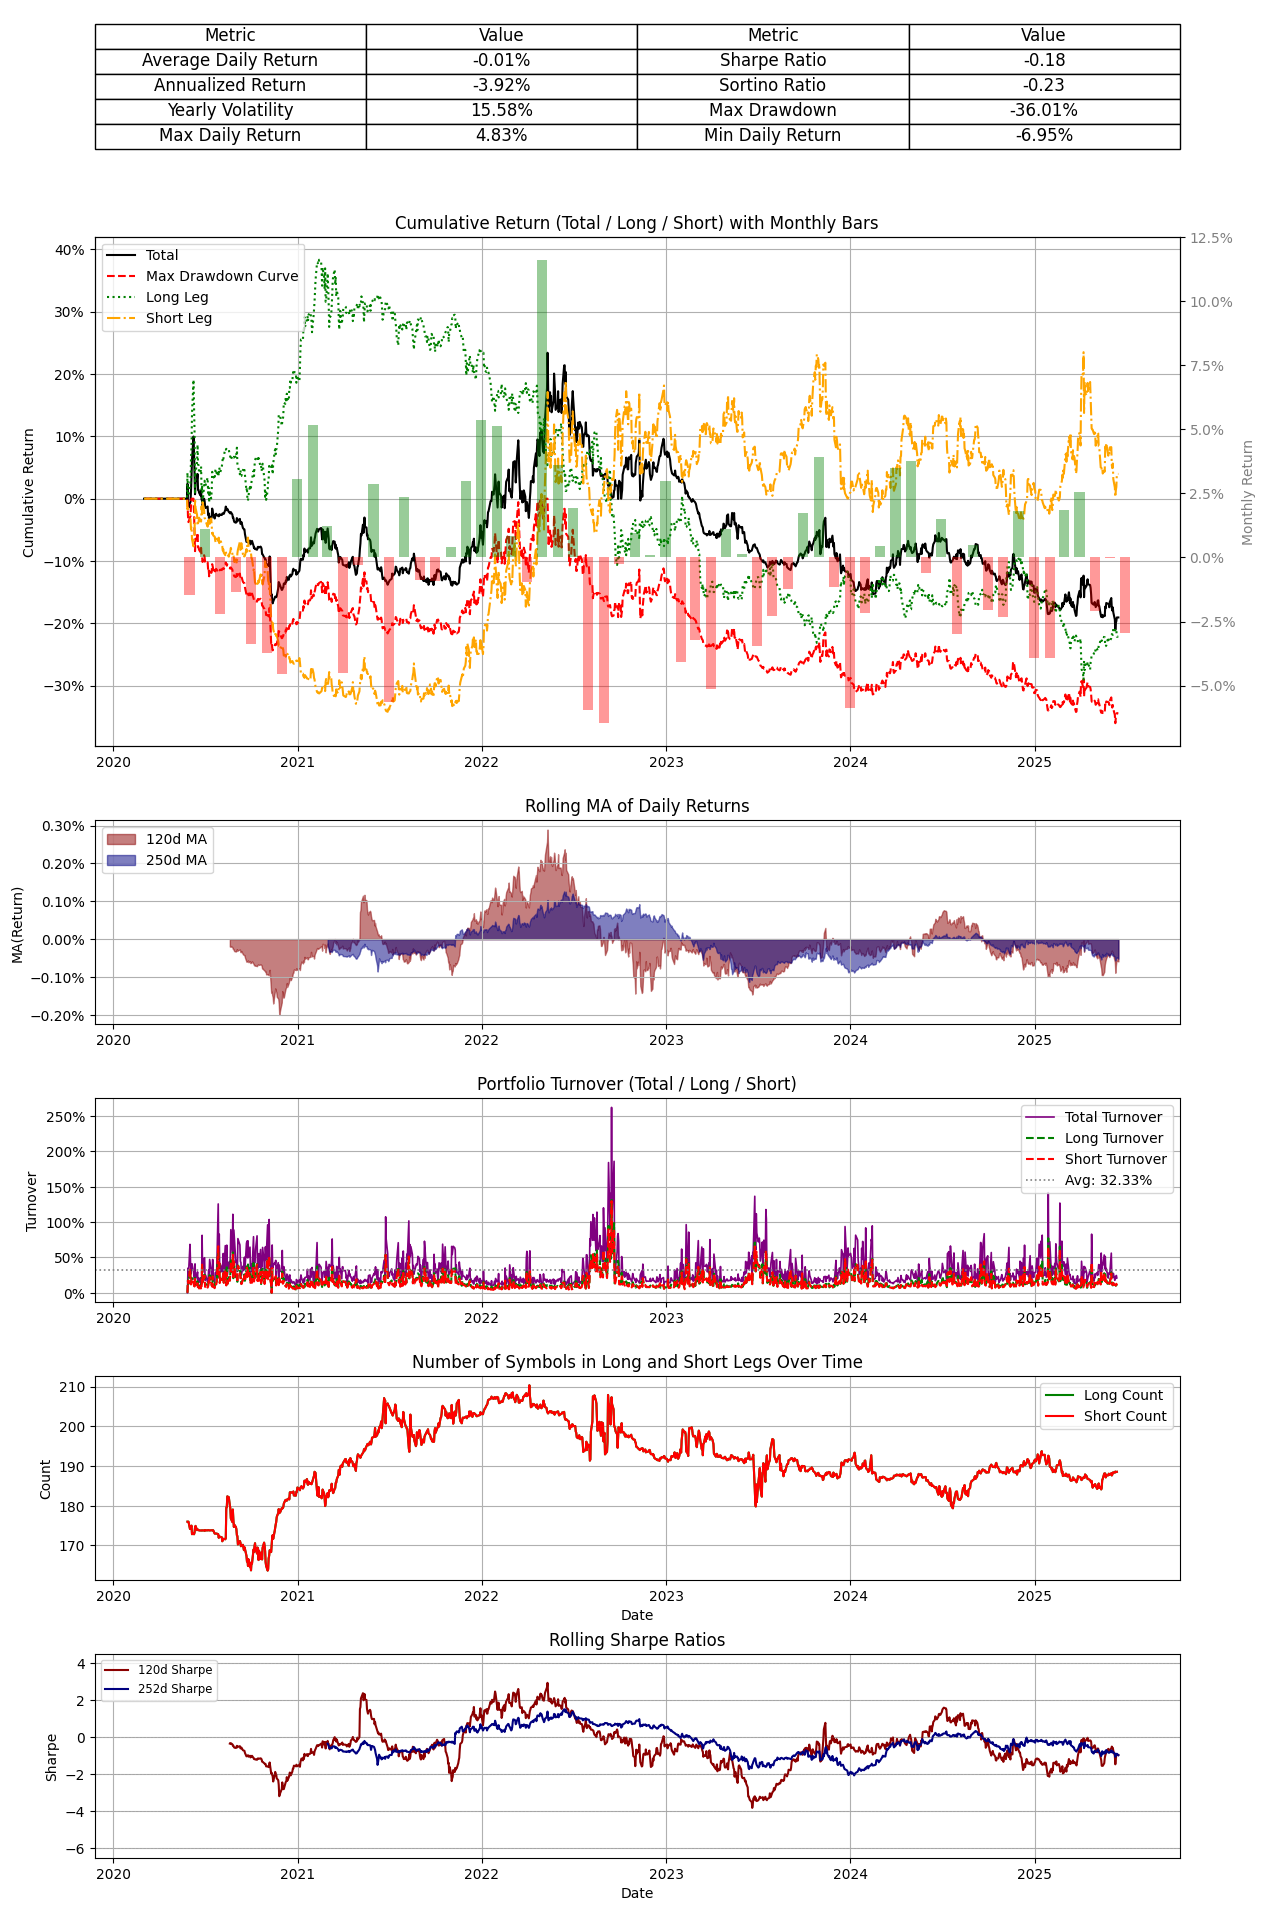

In [16]:
settings_momentum_multimanager = SimSettings()

multi_manager_momentum, top_longs_momentum, top_shorts_momentum, counts_momentum = run_multimanager_backtest(factors_df, returns, cap_flag, factor_weights_momentum, settings_momentum_multimanager)
analysis_momentum = PortfolioAnalyzer(multi_manager_momentum)
analysis_momentum.plot_full_performance(counts_df=counts_momentum)

2025-07-28 12:44:37 INFO     multi_manager Computing multimanager portfolio weights and counts...
2025-07-28 12:50:40 INFO     multi_manager Running backtest...


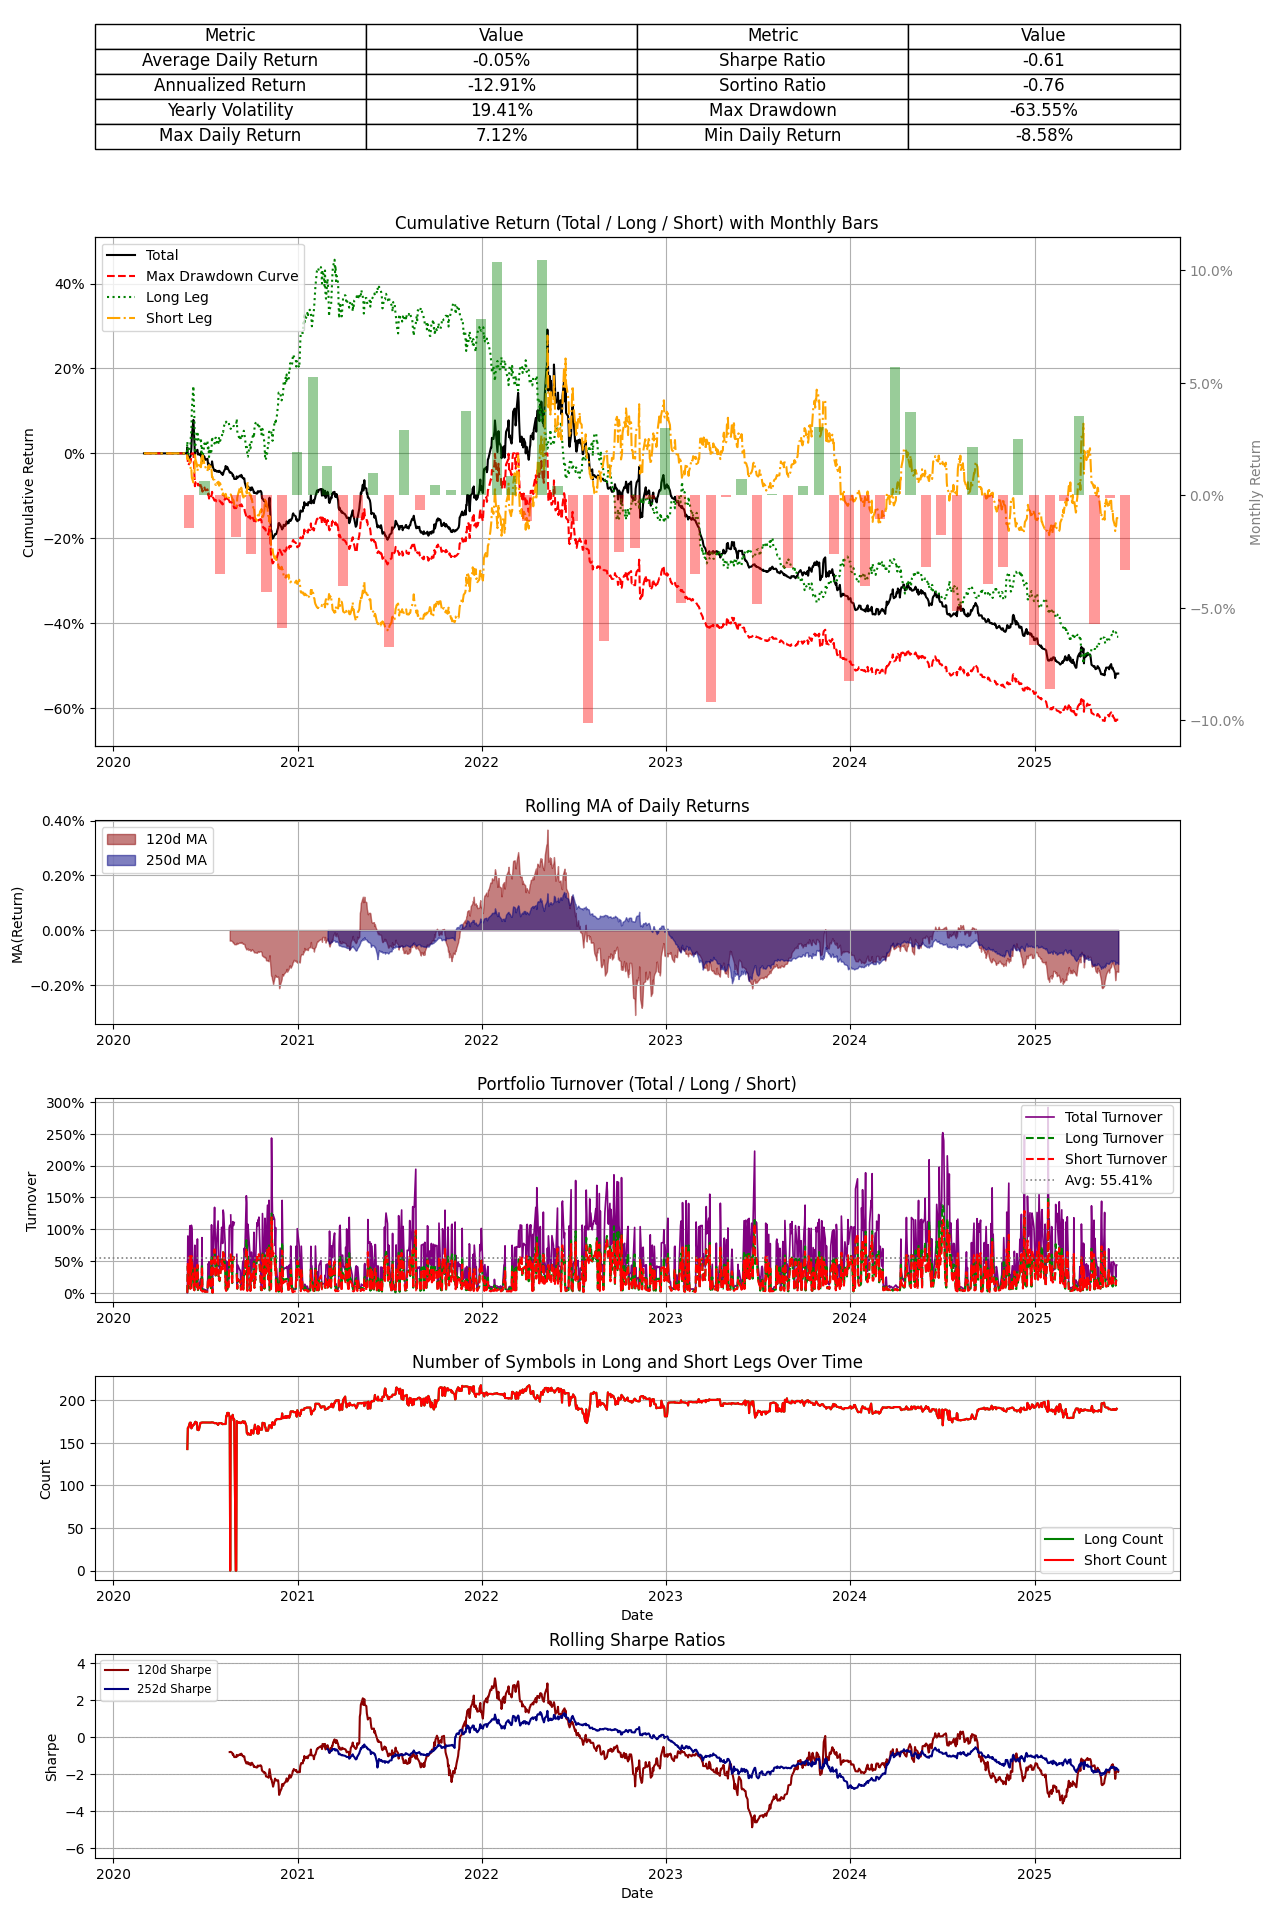

In [17]:
settings_mvo_multimanager = SimSettings()

multi_manager_mvo, top_longs_mvo, top_shorts_mvo, counts_mvo = run_multimanager_backtest(factors_df, returns, cap_flag, factor_weights_mvo, settings_mvo_multimanager)
analysis_mvo = PortfolioAnalyzer(multi_manager_mvo)
analysis_mvo.plot_full_performance(counts_df=counts_mvo)

## Optimization test Portfolio Simulation.py

In [ ]:
# # MVO composite factor
# composite_factor_mvo_default = pd.read_csv('data/composite_factors/composite_factor_mvo_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
# composite_factor_mvo_default = composite_factor_mvo_default.squeeze()
# settings_mvo_composite_default = SimSettings() 

# custom_feature = ts_decay(composite_factor_mvo_zscore, 80).rename("custom_feature")
# simulation_mvo_composite_default = Simulation('com_factor_mvo_default', custom_feature, settings_mvo_composite_default)
# simulation_mvo_composite.run()

In [ ]:
# composite_factor_mvo_optimized = pd.read_csv('data/composite_factors/composite_factor_mvo_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
# composite_factor_mvo_optimized = composite_factor_mvo_optimized.squeeze()
# settings_mvo_composite_optimized = SimSettings(method='mvo') 

# custom_feature = ts_decay(composite_factor_mvo_zscore, 80).rename("custom_feature")
# simulation_mvo_composite_optimized = Simulation('com_factor_mvo_optimized', custom_feature, settings_mvo_composite_optimized)
# simulation_mvo_composite_optimized.run()